# SOC 2025
Name-Rohan Shukla
<br>
Roll no. - 24B1274

This is my attempt at maing the final project for the SOC-2025.
<br>
The purpose of this project is to make a sentiment analyzer using LSTM layer, which predicts the effects of news headlines or small statements on the stocks of the company. It achieves this by analyzing whether the statement suggests something positive, negative or neutral about the situation.
<br>
Datasets used-
<ul>
<li>FinancialPhraseBank- this contains files varying according to the degree of agreement on various statemnets.</li>

<li>Pretrained word embeddings(GloVe)</li></ul>
Notes-
<br>
-) The access to the datasets has already been provided through gdown.
<br>
-) This project was an effort by me, with certain helps from AI wherever it was needed. The contribution of AI has been acknowledged wherever applicable.

### Importing the necessary packages.
Since, most of our training had been based on pytorch, we will try to implement this model using that only. Further, since we want to generalize to unseen statements, we can carry our several preprocessing steps on our natural sentences such as Tokenization,POS tagging, Lemmatization and Some sort of attention or equivalent mechanism.
<br>
With attention mechanism, it might not be that important to filter out stop words, especially so with the small size of the dataset.

In [1]:
#importing the common packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#importing special packages
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import gdown
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

#suggestion by AI, to mitigate unbalanced datasets
from sklearn.utils.class_weight import compute_class_weight
#Ai suggestion to handel variable length sequences
from torch.nn.utils.rnn import pad_sequence


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Fetching the dataset from google drive using gdown.
gdown has been used for this purpose as, while making this project, I faced several compatibility issues between Google Drive and Colab.
<br>
It's a good time saving alternative.

In [2]:
#the pre-trained GloVe embeddings
#https://drive.google.com/file/d/1IXWrebSjgAAWAGfCK20EQ6SbeLMXKO62/view?usp=drive_link
file_id = '1IXWrebSjgAAWAGfCK20EQ6SbeLMXKO62'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'glove.zip', quiet=False)

#the FinancialPhraseBank dataset
#https://drive.google.com/file/d/18sPHl-GktPZ6AJtY-miO7Js3wjwBtvMv/view?usp=sharing
file_id= '18sPHl-GktPZ6AJtY-miO7Js3wjwBtvMv'
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'FinancialPhraseBank-v1.0.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IXWrebSjgAAWAGfCK20EQ6SbeLMXKO62
From (redirected): https://drive.google.com/uc?id=1IXWrebSjgAAWAGfCK20EQ6SbeLMXKO62&confirm=t&uuid=bccdcead-d6c6-4c22-a5be-7eade1ae857f
To: /content/glove.zip
100%|██████████| 862M/862M [00:13<00:00, 63.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18sPHl-GktPZ6AJtY-miO7Js3wjwBtvMv
To: /content/FinancialPhraseBank-v1.0.zip
100%|██████████| 682k/682k [00:00<00:00, 35.9MB/s]


'FinancialPhraseBank-v1.0.zip'

In [3]:
!unzip glove.zip
!unzip FinancialPhraseBank-v1.0.zip

Archive:  glove.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
Archive:  FinancialPhraseBank-v1.0.zip
   creating: FinancialPhraseBank-v1.0/
  inflating: FinancialPhraseBank-v1.0/License.txt  
   creating: __MACOSX/
   creating: __MACOSX/FinancialPhraseBank-v1.0/
  inflating: __MACOSX/FinancialPhraseBank-v1.0/._License.txt  
  inflating: FinancialPhraseBank-v1.0/README.txt  
  inflating: __MACOSX/FinancialPhraseBank-v1.0/._README.txt  
  inflating: FinancialPhraseBank-v1.0/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank-v1.0/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank-v1.0/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank-v1.0/Sentences_AllAgree.txt  


### Reading and data preparation


In [4]:
#let's define the degree of agreement we want to use
# use one of 50,66,75,All below
deg_of_agree=66
with open(rf'/content/FinancialPhraseBank-v1.0/Sentences_{deg_of_agree}Agree.txt',encoding='utf-8',errors='ignore') as f:
  l=f.readlines()
print(l[0].strip())

#let's prepare the input(l) and target (t) lists separately
y=[]
for i,x in enumerate(l):
  if x.strip().endswith('@negative'):
    y.append(2)
  elif x.strip().endswith('@neutral'):
    y.append(0)
  else:
    y.append(1)
  l[i]=x.strip().split('@')[0]

#labels
labels={
    'positive':1,
    'neutral':0,
    'negative':2
}

#estimating the count of each category
count={}
for i in labels:
  count[i]=y.count(labels[i])
print(count)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral
{'positive': 1168, 'neutral': 2535, 'negative': 514}


In [5]:
# storing the embeddings
#select the embedding dimension you want to use
#enter one of 50,100,200,300 below
embedding_dim=100
embedding={}
with open(rf'/content/glove.6B.{embedding_dim}d.txt',encoding='utf-8',errors='ignore') as f:
  for line in f:
    values=line.split()
    word=values[0]
    coefs=np.array(values[1:],dtype='float32')
    embedding[word]=coefs


### Pre-processing the data and encoding it in vector form
In this section we use the classical tools like tokenizer,lemmatizer,etc. to get our dataset ready numerically.

In [6]:
#tokenization
tokenizer=TreebankWordTokenizer()
for i in range(len(l)):
  l[i]=tokenizer.tokenize(l[i])

#pos tagging
k=[]
for i in range(len(l)):
  k.append(pos_tag(l[i]))
print(k[0:2])

[[('According', 'VBG'), ('to', 'TO'), ('Gran', 'NNP'), (',', ','), ('the', 'DT'), ('company', 'NN'), ('has', 'VBZ'), ('no', 'DT'), ('plans', 'NNS'), ('to', 'TO'), ('move', 'VB'), ('all', 'DT'), ('production', 'NN'), ('to', 'TO'), ('Russia', 'NNP'), (',', ','), ('although', 'IN'), ('that', 'DT'), ('is', 'VBZ'), ('where', 'WRB'), ('the', 'DT'), ('company', 'NN'), ('is', 'VBZ'), ('growing', 'VBG'), ('.', '.')], [('Technopolis', 'NNP'), ('plans', 'VBZ'), ('to', 'TO'), ('develop', 'VB'), ('in', 'IN'), ('stages', 'NNS'), ('an', 'DT'), ('area', 'NN'), ('of', 'IN'), ('no', 'DT'), ('less', 'JJR'), ('than', 'IN'), ('100,000', 'CD'), ('square', 'JJ'), ('meters', 'NNS'), ('in', 'IN'), ('order', 'NN'), ('to', 'TO'), ('host', 'VB'), ('companies', 'NNS'), ('working', 'VBG'), ('in', 'IN'), ('computer', 'NN'), ('technologies', 'NNS'), ('and', 'CC'), ('telecommunications', 'NNS'), (',', ','), ('the', 'DT'), ('statement', 'NN'), ('said', 'VBD'), ('.', '.')]]


In [7]:
# defining the function to use pos_tags for lemmatization
def get_pos_tag(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [8]:
#lemmatization
lemmatizer=WordNetLemmatizer()
for i in range(len(k)):
  for j in range(len(k[i])):
    k[i][j]=lemmatizer.lemmatize(k[i][j][0].lower(),pos=get_pos_tag(k[i][j][1]))
print(k[0:2])

[['accord', 'to', 'gran', ',', 'the', 'company', 'have', 'no', 'plan', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'be', 'where', 'the', 'company', 'be', 'grow', '.'], ['technopolis', 'plan', 'to', 'develop', 'in', 'stage', 'an', 'area', 'of', 'no', 'less', 'than', '100,000', 'square', 'meter', 'in', 'order', 'to', 'host', 'company', 'work', 'in', 'computer', 'technology', 'and', 'telecommunication', ',', 'the', 'statement', 'say', '.']]


In [9]:
#Counting the frequency of each word, to later use stop_word filtering based on frequency.
freq={}
for i in range(len(k)):
  for j in range(len(k[i])):
    if k[i][j] in freq:
      freq[k[i][j]]+=1
    else:
      freq[k[i][j]]=1


In [10]:
#Stop word filtering
#here we define the minimum and maximum thresholds a word must satisfy in order to significantly contribute to the sentiment of sentence.
lower_lim=1
upper_lim=500
stop_words=[k for k,v in freq.items() if ((v<lower_lim) or (v>upper_lim))]
stop_words

['to',
 ',',
 'the',
 'company',
 'have',
 'be',
 '.',
 'in',
 'of',
 'and',
 'it',
 "'s",
 'for',
 'a',
 'from',
 'by',
 'eur',
 'mn',
 'will',
 'on']

In [11]:
#vocab
vocab=list(freq.keys())
len(vocab)

9400

In [12]:
for i in vocab:
  if i in stop_words:
    vocab.remove(i)
temp=[]
for i in range(len(k)):
  temp_in=[]
  for j in range(len(k[i])):
    if k[i][j] not in stop_words:
      temp_in.append(k[i][j])
  temp.append(temp_in)
k=temp
len(vocab)

9382

In [13]:
#adding a padding token to the embedding that we will use use pad the sequences to the same length
#embedding['<PAD>']=np.zeros(dim)

#setting a reasonable cutoff for padding
#lengths=[len(s) for s in k]
#utoff=np.percentile(lengths,90)
#print(cutoff)
#first we will try to train without batching to let lstm handle the necessary info only.
for i in range(len(k)):
  for j in range(len(k[i])):
    k[i][j]=embedding.get(k[i][j],np.zeros(embedding_dim))


### Let us define the hyperparameters and model
Here, we use the lstm layer and default hidden state starting point of a zero vector. Now as we have a huge inequality in the lengths of the sentences, instead of using padding, we first try to not use batches and length and let LSTM handle the variable lengths.

In [14]:
#AI generated procedure to deal with imbalance in the number of sentences available for each label
device='cuda' if torch.cuda.is_available() else 'cpu'
# Compute weights
classes = np.array([0, 1, 2])  # neutral, positive, negative (example)
y_labels = y  # your full label list as a numpy array
weights = compute_class_weight(class_weight='balanced',classes=classes, y=y_labels)

# Convert to tensor and use in loss
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(class_weights)

tensor([0.5545, 1.2035, 2.7348])


In [15]:
#hyperparameters
embedding_dim=embedding_dim
hidden_size=12
num_classes=3
drop_out=0.35
attention_size=8
num_epochs=10
learning_rate=0.001
batch_size=1 #fixed

In [16]:
#model
class model(nn.Module):
  def __init__(self,hidden_size,num_classes,attention_size,criterion,drop_out):
    super().__init__()
    self.l1=nn.LSTM(embedding_dim,hidden_size,batch_first=True) #we plan to use only one batch
    self.actv=nn.ReLU()
    self.out=nn.Linear(hidden_size,num_classes)
    self.Key=nn.Linear(embedding_dim,attention_size,bias=False)
    self.Query=nn.Linear(embedding_dim,attention_size,bias=False)
    self.Val=nn.Linear(embedding_dim,embedding_dim,bias=False)
    self.loss=criterion
    self.dropout=nn.Dropout(drop_out)
  def forward(self,x,targets=None):
    # x is shaped as (1,seq_len,embedding_dim)
    output=self.attention(x)
    output,_=self.l1(output)
    output=output[:,-1,:]
    output=self.actv(output)
    output=self.dropout(output)
    output=self.out(output)

    if targets is not None:
      loss=self.loss(output,targets)
      return output,loss
    else:
      return output

  def attention(self,x):
    #x is a torch tensor shaped as (1,seq_len,dim)
    key=self.Key(x)
    query=self.Query(x)
    val=self.Val(x) #(1,seq_len,embedding_dim)

    scores=torch.bmm(query,key.transpose(1,2))/(key.size(-1)**0.5) #(1,seq_len,seq_len)
    attention_weights=F.softmax(scores,dim=-1) #(1,seq_len,seq_len)
    attended_input=torch.bmm(attention_weights,val) #(1,seq_len,embedding_dim)
    return attended_input

### Splitting the dataset.

In [17]:
#splitting the datasets into train, test and cross validation
train_frac=0.85
cross_val=0.1
test_frac=0.05
X_train,X_test,y_train,y_test=train_test_split(k,y,test_size=(test_frac+cross_val),random_state=1)
X_test,X_cv,y_test,y_cv=train_test_split(X_test,y_test,test_size=(cross_val/(test_frac+cross_val)),random_state=1)


### Workaround for Variable-Length Sequences
Instead of padding, we can use a custom `Dataset` and `collate_fn` to handle variable-length sequences directly in the DataLoader.

**Note-** This whole section was implemented with the help of AI. The reason for that is the traditional dataloader expects data with equal sized sequences, but we are avoididng that, as we prefer not padding the input to prevent considerable loss of information.

In [18]:
from torch.utils.data import Dataset

class VariableLengthDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Convert the sequence to a tensor
        sequence_tensor = torch.tensor(self.sequences[idx], dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence_tensor, label_tensor

# Custom collate function to handle variable length sequences
def variable_length_collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch]) # Labels should have the same shape

    # Return sequences as a list of tensors
    return sequences, labels

# Create custom datasets
train_dataset = VariableLengthDataset(X_train, y_train)
cv_dataset = VariableLengthDataset(X_cv, y_cv)
test_dataset = VariableLengthDataset(X_test, y_test)

# Create DataLoaders with the custom collate function and batch_size=1
# Note: With batch_size=1, the collate_fn will be called for each individual item,
# and the "batch" in collate_fn will be a list containing a single (sequence, label) tuple.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=variable_length_collate_fn)
cv_loader = DataLoader(cv_dataset, batch_size=batch_size, collate_fn=variable_length_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=variable_length_collate_fn)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(cv_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Number of training batches: 3584
Number of validation batches: 422
Number of testing batches: 211


###Training loop
This is the main loop that we will use to train our model on the training dataset.

In [19]:
#defining the model and optimizer
prediction_model=model(hidden_size,num_classes,attention_size,criterion,drop_out)
optimizer=torch.optim.Adam(prediction_model.parameters(),lr=learning_rate,weight_decay=1e-5) #weight_decay helps perform regularization by minimizing weights
device='cuda' if torch.cuda.is_available() else 'cpu'
prediction_model.to(device)

model(
  (l1): LSTM(100, 12, batch_first=True)
  (actv): ReLU()
  (out): Linear(in_features=12, out_features=3, bias=True)
  (Key): Linear(in_features=100, out_features=8, bias=False)
  (Query): Linear(in_features=100, out_features=8, bias=False)
  (Val): Linear(in_features=100, out_features=100, bias=False)
  (loss): CrossEntropyLoss()
  (dropout): Dropout(p=0.35, inplace=False)
)

In [20]:
#defining the lists to store the losses
train_losses=[]
validation_losses=[]
f1_scores=[]

In [21]:
#the loop
prediction_model.train()
for i in range(num_epochs):
  total_train_loss=0.0
  count=0
  for x_batch,y_batch in train_loader:
    #print(type(x_batch), type(x_batch[0]), x_batch[0].shape)
    x_batch = torch.stack(x_batch).to(torch.float32).to(device)  # (batch, seq_len, emb_dim)
    y_batch =y_batch.long().to(device)
    output,loss=prediction_model(x_batch,y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_train_loss+=loss
    count+=1
  train_losses.append(total_train_loss/count)
  prediction_model.eval()
  val_loss=0.0
  Scores=[]
  actual=[]
  for x_batch,y_batch in cv_loader:
    x_batch = torch.stack(x_batch).to(torch.float32).to(device)  # (batch, seq_len, emb_dim)
    y_batch = y_batch.long().to(device)
    with torch.no_grad():
      output,loss=prediction_model(x_batch,y_batch)
    preds=torch.argmax(output,dim=1) #remember that output is just raw logit, this line converts it into actual predictions
    val_loss+=loss
    Scores.extend(preds.cpu().numpy())
    actual.extend(y_batch.cpu().numpy())
  validation_losses.append(val_loss/len(cv_loader))
  #In the following line, the feelings were mine, the code was given by AI :-)
  f1=f1_score(actual, Scores, average='weighted')
  f1_scores.append(f1)
  prediction_model.train()


/tmp/ipython-input-18-3107748672.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  sequence_tensor = torch.tensor(self.sequences[idx], dtype=torch.float)


In [22]:
train_losses=[i.item() for i in train_losses]
validation_losses=[i.item() for i in validation_losses]


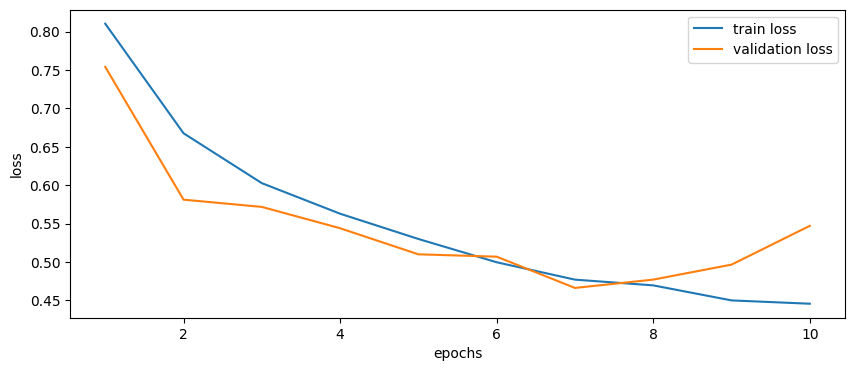

In [23]:
#plotting the loss functions
figure=plt.figure(figsize=(10,4))
plt.plot(range(1,num_epochs+1),train_losses,label="train loss")
plt.plot(range(1,num_epochs+1),validation_losses,label="validation loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

/tmp/ipython-input-24-3357419074.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


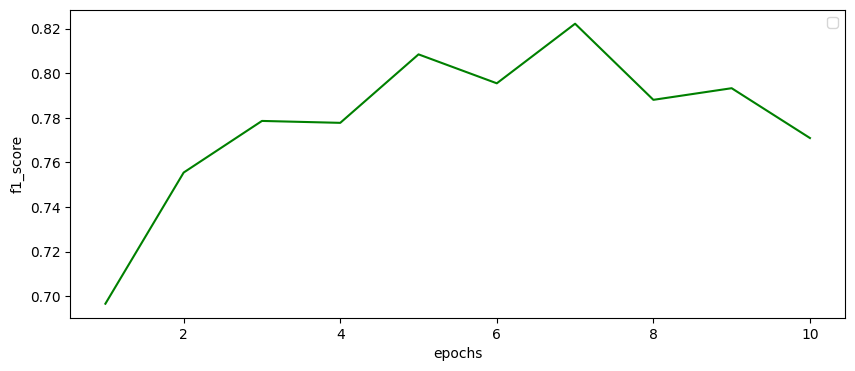

In [24]:
#plotting the f1_scores
figure=plt.figure(figsize=(10,4))
plt.plot(range(1,num_epochs+1),f1_scores,color='green')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('f1_score')
plt.show()

###Remarks about training
As seen from the plots the model suffers from overfitting, especiallay visible after epoch-7. I think this can slightly be improves by tweaking the parameters, but overall the dataset we are using is small, and hence it becomes difficult to improve it much.
<br>
So, without high expectations, for the sake of completion, let us evaluate the model on the test set.

In [28]:
#evaluation
test_eval_losses=[]
scores=[]
pred=[]
actual=[]
with torch.no_grad():
  for x_batch,y_batch in test_loader:
    x_batch=torch.stack(x_batch).to(torch.float32).to(device)
    y_batch=y_batch.long().to(device)
    output,loss=prediction_model(x_batch,y_batch)
    pred.extend(torch.argmax(output,dim=1).cpu().numpy())
    actual.extend(y_batch.cpu().numpy())
    test_eval_losses.append(loss.item())
test_eval_losses=np.mean(test_eval_losses)
pred=np.array([i.item() for i in pred],dtype=int)
actual=np.array([i.item() for i in actual],dtype=int)
acc=(pred==actual).sum()/len(pred)
print(f1_score(actual,pred,average='weighted'))
print(acc)

0.7215060622394123
0.7251184834123223


###Concluding remarks
This was a beginner level into to building an LSTM based sentiment analyzer.The accuracy was not so encouraging, but again the limitation of the size of dataset has to be taken into account.
<br>
Overall, it was a fun but very demanding first project to build for me as a beginner, but I cherish the experience.